## Spatial Analysis

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import contextily as ctx

from shapely.geometry import LineString

from utils import helper

In [2]:
geo_antennas = gpd.read_file('../data/affected_btsid/affected_btsid.shp')
geo_antennas.crs = 'EPSG:4674'

zonas_geo = gpd.read_file('../data/zonas/ZONA_C17.shp')
zonas_geo.crs = 'EPSG:4674'

zonas_se = pd.read_csv('../data/auxvars_zone_census.csv.tar.gz')

zonas_geo.GEOCODIGO = zonas_geo.GEOCODIGO.astype(str)
zonas_se.ZONA = zonas_se.ZONA.astype(str)

zonas_geo = zonas_geo.merge(zonas_se, left_on='GEOCODIGO', right_on='ZONA')

geo_antennas = geo_antennas.sjoin(zonas_geo, how='left', predicate='intersects')

In [3]:
warned_towers = pd.read_csv('../data/warned_towers.csv')

warned_towers['date'] = pd.to_datetime(warned_towers['date'])

warned_towers = warned_towers.merge(geo_antennas[['bts_id', 'geometry']], on='bts_id', how='left')
warned_towers = gpd.GeoDataFrame(warned_towers, geometry='geometry', crs='EPSG:4674')

In [4]:
chile_border_adm0 = gpd.read_file('../data/data_meta/borders/chl_admbnda_adm0_bcn_20211008.shp')
chile_border_adm1 = gpd.read_file('../data/data_meta/borders/chl_admbnda_adm1_bcn_20211008.shp')
chile_border_adm3 = gpd.read_file('../data/data_meta/borders/chl_admbnda_adm3_bcn_20211008.shp')
incendio_gpd = gpd.read_file('../data/ED_AreasAfectadasIncendio_Valparaiso/ED_AreasAfectadasIncendio_Valparaiso.shp')

In [5]:
homelocations_merged=pd.read_parquet('../data_created/homelocations_merged_cleaned.parquet')
evacuated_people = helper.upload_list_txt('../data_created/evacuated.txt')

In [6]:
homelocations_merged_evacuated=homelocations_merged[homelocations_merged['PHONE_ID'].isin(evacuated_people)].reset_index(drop=True)

## The home locations of Likely evacuated people  

In [7]:
# Count by home location
spatial_homelocations=homelocations_merged_evacuated[['PHONE_ID', 'home_bts_id']].drop_duplicates().groupby('home_bts_id').count().reset_index()

# Add geo coordinates
spatial_homelocations=spatial_homelocations.merge(warned_towers[['bts_id', 'geometry']].drop_duplicates(), left_on='home_bts_id', right_on='bts_id', how='left')
spatial_homelocations=gpd.GeoDataFrame(spatial_homelocations, geometry='geometry', crs=4326)

In [8]:
spatial_homelocations['town_size'] = pd.cut(spatial_homelocations['PHONE_ID'], 
                                            bins=[0, 100, 400, 1000, 1566], 
                                            labels=['\u2264100', '101-400', '401-1000', '\u003C1000'],
                                            right=True)

In [9]:
spatial_homelocations['town_size'].value_counts()

town_size
101-400     53
≤100        35
401-1000    21
<1000        3
Name: count, dtype: int64

In [10]:
geo_antennas = geo_antennas.to_crs(epsg=3857)
zonas_geo = zonas_geo.to_crs(epsg=3857)
incendio_gpd = incendio_gpd.to_crs(epsg=3857)
warned_towers = warned_towers.to_crs(epsg=3857)
chile_border_adm1 = chile_border_adm1.to_crs(epsg=3857)
chile_border_adm3 = chile_border_adm3.to_crs(epsg=3857)
spatial_homelocations = spatial_homelocations.to_crs(epsg=3857)

The home locations of Likely evacuated people  

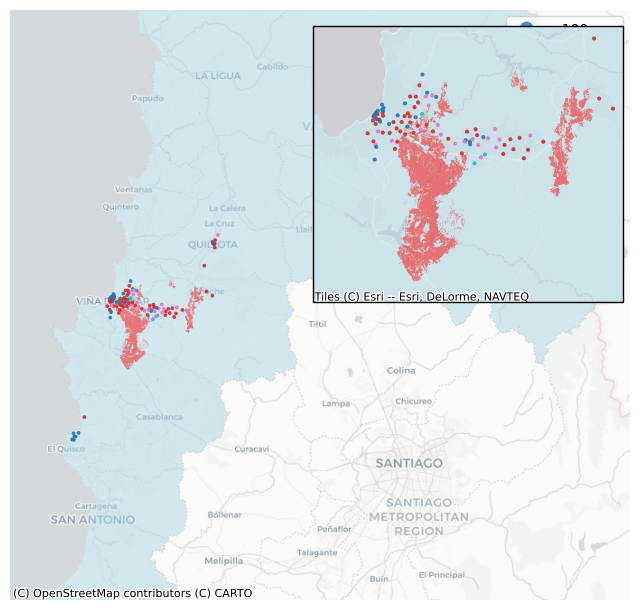

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))  

## Main Figure
chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=ax, alpha=0.5)
incendio_gpd.plot(color='red', alpha=0.5, ax=ax)
spatial_homelocations.plot(column='town_size', markersize=3, ax=ax, legend=True, alpha=0.8)

ax.set_xlim([-0.8*1e7, -0.779*1e7])
ax.set_ylim([-4*1e6, -3.8*1e6])
ax.set_axis_off()

# Add basemap to the main figure
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)


## Inset 

# Create an inset figure (affected_towers)
ax_inset = inset_axes(ax, width="50%", height="50%",
                      loc='upper right')
chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=ax_inset, alpha=0.5)
incendio_gpd.plot(color='red', alpha=0.5, ax=ax_inset)
spatial_homelocations.plot(column='town_size', markersize=4, ax=ax_inset, legend=False, alpha=0.8)

# Set limits for the inset plot
ax_inset.set_xlim([-0.7975*1e7, -0.793*1e7])
ax_inset.set_ylim([-3.925*1e6, -3.885*1e6])

ax_inset.set_axis_off()

# Add basemap to the inset figure
ctx.add_basemap(ax_inset, source=ctx.providers.Esri.WorldGrayCanvas)
                # crs=geo_antennas.crs)

# Add a distinctive frame to the inset axis
rect = plt.Rectangle(
    (ax_inset.get_position().x0, ax_inset.get_position().y0),
    ax_inset.get_position().width,
    ax_inset.get_position().height,
    linewidth=1,  # Thickness of the border
    edgecolor='black',  # Color of the border
    facecolor='none',  # No fill inside the frame
    transform=fig.transFigure,  # Make sure the rectangle aligns with the figure coordinates
    linestyle='-',  # Solid line style, can be changed to '--', ':', etc.
    zorder=10       # Ensures the frame appears above other elements
)

fig.patches.append(rect)


# plt.savefig('visuals_/map_warned_towers.jpg', dpi=300)

plt.show();

Homelocations of Likely Evacuated People. Shows how many likely evacuated people reside per each affected tower. 

- 101-400     53
- ≤100        35
- 401-1000    21
- <1000        3


## The current locations of Likely evacuated people on 2 February

In [12]:
from scipy.stats import pearsonr

def compare_activity_previous_day(df, day, day_before, warned_towers, spatial_homelocations):

    day=pd.to_datetime(day)

    if not day_before:
        day_before=day-pd.Timedelta(days=1)
    else:
        day_before=pd.to_datetime(day_before)
    
    spatial_currentlocations_day=(homelocations_merged_evacuated[(homelocations_merged_evacuated['date']==day)
                                &(homelocations_merged_evacuated['current_bts_id']==homelocations_merged_evacuated['home_bts_id'])])

    spatial_currentlocations_daybefore=(homelocations_merged_evacuated[(homelocations_merged_evacuated['date']==day_before)
                                &(homelocations_merged_evacuated['current_bts_id']==homelocations_merged_evacuated['home_bts_id'])])


    def further_processing(df, warned_towers=warned_towers, spatial_homelocations=spatial_homelocations):
        df=df[['PHONE_ID', 'current_bts_id']].drop_duplicates().groupby('current_bts_id').count().reset_index()
        df=df.merge(warned_towers[['bts_id', 'geometry']].drop_duplicates(), left_on='current_bts_id', right_on='bts_id', how='left')
        df=gpd.GeoDataFrame(df, geometry='geometry', crs=3857)
        df['town_size'] = pd.cut(spatial_homelocations['PHONE_ID'], 
                                            bins=[0, 100, 400, 1000, 1566], 
                                            labels=['\u2264100', '101-400', '401-1000', '\u003C1000'],
                                            right=True)
        # print(df['town_size'].value_counts())
        df=df.merge(spatial_homelocations[['home_bts_id','PHONE_ID']], 
                    left_on='current_bts_id', right_on='home_bts_id',
                    how='left', suffixes=('', '_home'))

        # print(pearsonr(df['PHONE_ID'], df['PHONE_ID_home']))
        
        return df

    spatial_currentlocations_day=further_processing(spatial_currentlocations_day)
    spatial_currentlocations_daybefore=further_processing(spatial_currentlocations_daybefore)

    spatial_currentlocations_daybefore=spatial_currentlocations_daybefore.merge(spatial_currentlocations_day[['current_bts_id','PHONE_ID']], 
                                    left_on='current_bts_id', right_on='current_bts_id',
                                    how='outer', suffixes=('', '_after'))

    spatial_currentlocations_daybefore['PHONE_ID_after']=spatial_currentlocations_daybefore['PHONE_ID_after'].fillna(0)

    filtered_data = spatial_currentlocations_daybefore[['PHONE_ID', 'PHONE_ID_after']].dropna()    
    print(pearsonr(filtered_data['PHONE_ID'], filtered_data['PHONE_ID_after']))
    
    spatial_currentlocations_daybefore['perc_change']=((spatial_currentlocations_daybefore['PHONE_ID_after']-
                                                       spatial_currentlocations_daybefore['PHONE_ID'])/
                                                       spatial_currentlocations_daybefore['PHONE_ID']*100)
    
    return spatial_currentlocations_daybefore

In [13]:
spatial_currentlocations_0202=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-02', day_before='2024-01-26', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)
spatial_currentlocations_0203=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-03', day_before='2024-01-27', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)
spatial_currentlocations_0204=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-04', day_before='2024-01-28', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)
spatial_currentlocations_0205=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-05', day_before='2024-01-29', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)
spatial_currentlocations_0206=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-06', day_before='2024-01-30', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)
spatial_currentlocations_0207=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-07', day_before='2024-01-31', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)
spatial_currentlocations_0208=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-08', day_before='2024-02-01', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)
spatial_currentlocations_0209=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-09', day_before='2024-02-02', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)
spatial_currentlocations_0210=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-10', day_before='2024-01-27', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)
spatial_currentlocations_0211=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-11', day_before='2024-01-28', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)
spatial_currentlocations_0212=compare_activity_previous_day(homelocations_merged_evacuated, day='2024-02-12', day_before='2024-01-29', warned_towers=warned_towers, spatial_homelocations=spatial_homelocations)

PearsonRResult(statistic=0.9969900983810783, pvalue=6.84075119854799e-123)
PearsonRResult(statistic=0.3207286636788369, pvalue=0.0005992192369924731)
PearsonRResult(statistic=0.6331987468779731, pvalue=8.85386320023575e-14)
PearsonRResult(statistic=0.7891532453830331, pvalue=8.095028080881325e-25)
PearsonRResult(statistic=0.8204063397394135, pvalue=3.194149825021748e-28)
PearsonRResult(statistic=0.8159148877020959, pvalue=6.208179037869572e-28)
PearsonRResult(statistic=0.8146127326723274, pvalue=1.5254500043354053e-27)
PearsonRResult(statistic=0.8131422614897117, pvalue=2.248916785431389e-27)
PearsonRResult(statistic=0.8337795266809372, pvalue=6.90564682478171e-30)
PearsonRResult(statistic=0.9549315681114401, pvalue=2.538631427293813e-59)
PearsonRResult(statistic=0.9559499263007731, pvalue=7.507852416516506e-60)


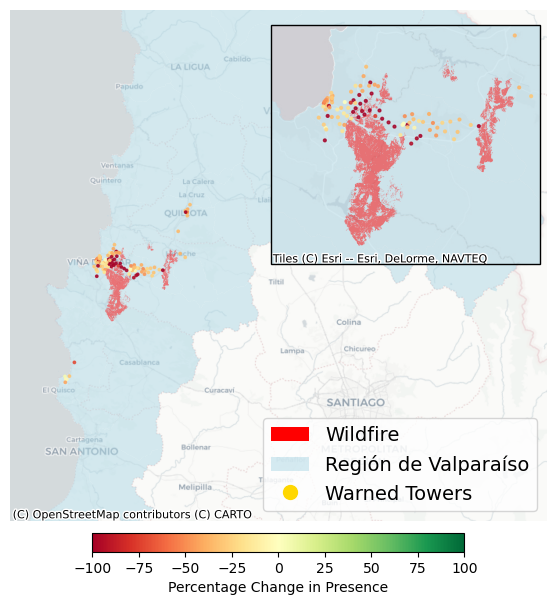

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))  

## Main Figure
chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=ax, alpha=0.5)
incendio_gpd.plot(color='red', alpha=0.5, ax=ax)
spatial_currentlocations_0203.plot(column='perc_change', markersize=3, ax=ax, legend=True, alpha=0.8,
                                   vmin=-100, vmax=100, 
                                   cmap='RdYlGn',
                                   legend_kwds={'label': "Percentage Change in Presence",
                                                 'orientation': "horizontal",
                                                 'shrink': 0.6,
                                                 'pad':0.02})

ax.set_xlim([-0.8*1e7, -0.779*1e7])
ax.set_ylim([-4*1e6, -3.8*1e6])
ax.set_axis_off()

# Add basemap to the main figure
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)


## Inset 

# Create an inset figure (affected_towers)
ax_inset = inset_axes(ax, width="50%", height="50%",
                      loc='upper right')
chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=ax_inset, alpha=0.5)
incendio_gpd.plot(color='red', alpha=0.5, ax=ax_inset)
spatial_currentlocations_0203.plot(column='perc_change', markersize=4, ax=ax_inset, legend=False, alpha=0.8,
                                   vmin=-100, vmax=100, 
                                   cmap='RdYlGn')

# Set limits for the inset plot
ax_inset.set_xlim([-0.7975*1e7, -0.793*1e7])
ax_inset.set_ylim([-3.925*1e6, -3.885*1e6])

ax_inset.set_axis_off()

# Add basemap to the inset figure
ctx.add_basemap(ax_inset, source=ctx.providers.Esri.WorldGrayCanvas)
                # crs=geo_antennas.crs)

# Add a distinctive frame to the inset axis
rect = plt.Rectangle(
    (ax_inset.get_position().x0, ax_inset.get_position().y0),
    ax_inset.get_position().width,
    ax_inset.get_position().height,
    linewidth=1,  # Thickness of the border
    edgecolor='black',  # Color of the border
    facecolor='none',  # No fill inside the frame
    transform=fig.transFigure,  # Make sure the rectangle aligns with the figure coordinates
    linestyle='-',  # Solid line style, can be changed to '--', ':', etc.
    zorder=10       # Ensures the frame appears above other elements
)

fig.patches.append(rect)

rect1 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color='red', alpha=1)
rect2 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color='lightblue', alpha=0.5)
rect3 = plt.Line2D([0], [0], marker='o', color='gold', linewidth=0, markersize=10)
handles_to_append = [rect1, rect2, rect3]

# Explicitly specify handles and labels for the legend
handles, labels = [], []
for line in ax.get_lines():
    handles.append(line)
    labels.append(line.get_label())
handles.extend(handles_to_append)

labels_to_append = ['Wildfire', 'Región de Valparaíso', 'Warned Towers']
labels.extend(labels_to_append)

ax.legend(handles, labels, fontsize=14, loc='lower right')


# plt.savefig('visuals_/map_warned_towers.jpg', dpi=300)

plt.show();

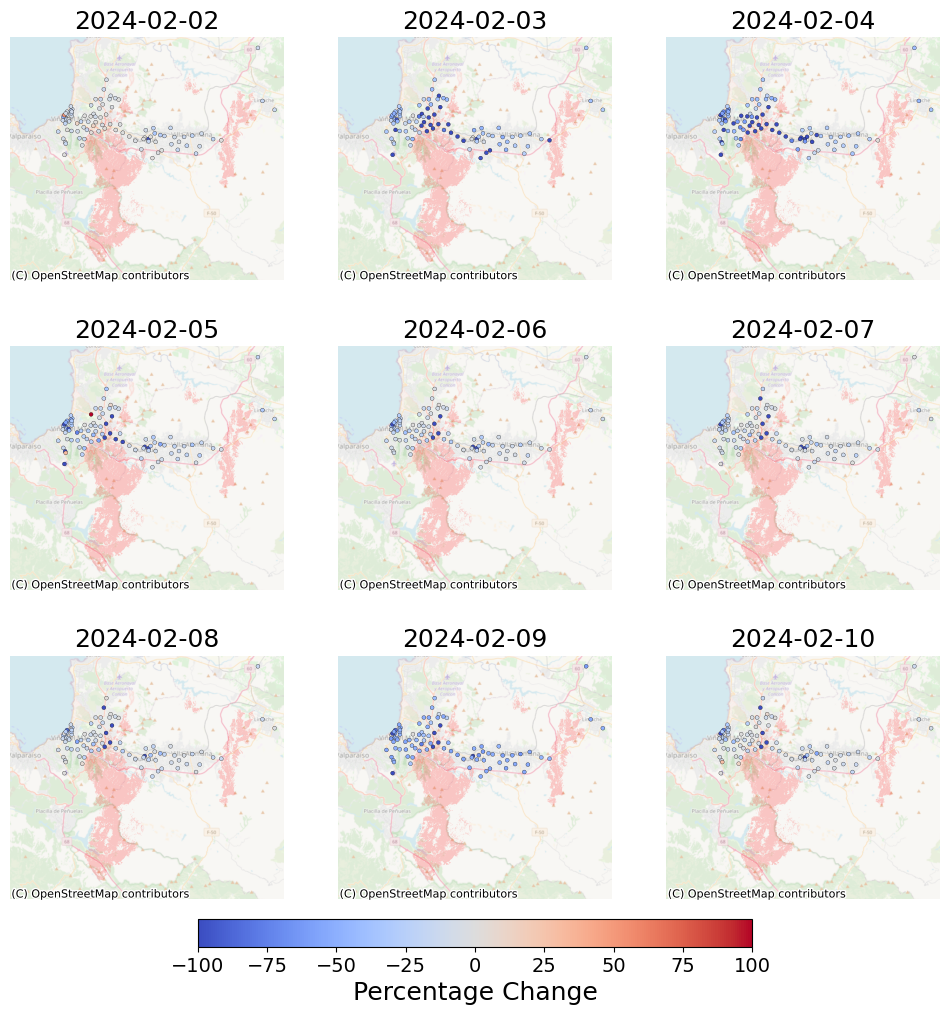

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# List of datasets and the corresponding names
datasets = [
    spatial_currentlocations_0202,
    spatial_currentlocations_0203,
    spatial_currentlocations_0204,
    spatial_currentlocations_0205,  
    spatial_currentlocations_0206,
    spatial_currentlocations_0207,
    spatial_currentlocations_0208,
    spatial_currentlocations_0209,
    spatial_currentlocations_0210
]

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

day='2024-02-02'
day=pd.to_datetime(day)

# Iterate over the datasets and subplot positions
for i, (dataset, ax) in enumerate(zip(datasets, axs.flatten())):
    chile_border_adm1[chile_border_adm1['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightgray', ax=ax_inset, alpha=0.5,
                                                                               edgecolor='black', linestyle='--', linewidth=1)
    
    incendio_gpd.plot(color='red', alpha=0.2, ax=ax)
    
    # Plot the dataset
    dataset.plot(column='perc_change', ax=ax, legend=False, alpha=1,
                 vmin=-100, vmax=100, cmap='coolwarm',
                 markersize=8, edgecolor='black', linewidth=0.2)
    
    # Set the limits for each subplot
    ax.set_xlim([-0.7975*1e7, -0.793*1e7])
    ax.set_ylim([-3.925*1e6, -3.885*1e6])
    
    ax.set_axis_off()  # Turn off the axis for a cleaner look

    ax.set_title(f"{day.strftime('%Y-%m-%d')}", fontsize=18)

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    for img in ax.get_images():
        img.set_alpha(0.5)

    day+=pd.Timedelta(days=1)


# Assuming `axs` and the plot have been created already
# Create the colorbar as the legend for 'perc_change'
norm = mpl.colors.Normalize(vmin=-100, vmax=100)
cmap = mpl.cm.coolwarm
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='horizontal', fraction=0.03, pad=0.04)
cbar.set_label('Percentage Change', fontsize=18)
cbar.ax.tick_params(labelsize=14)

# Adjust layout to prevent overlap
fig.subplots_adjust(bottom=0.15)

fig.savefig('../visuals_created/map_changes_hotspots',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)

# Show the plot
plt.show()


## Flows

In [16]:
def create_gdf_flows(df, day, day_before, zonas_geo):

    day=pd.to_datetime(day)

    if not day_before:
        day_before=day-pd.Timedelta(days=1)
    else:
        day_before=pd.to_datetime(day_before)

    day_base=day-pd.Timedelta(weeks=1)
    day_before_base=day_before-pd.Timedelta(weeks=1)

    spatial_currentlocations_daybefore=(df[(df['date'].isin([day_before]))
                                &(df['current_bts_id']==df['home_bts_id'])])

    spatial_currentlocations_day=(df[(homelocations_merged_evacuated['date'].isin([day]))])

    spatial_currentlocations_daybeforebase=(df[(df['date'].isin([day_before_base]))
                                &(df['current_bts_id']==df['home_bts_id'])])

    spatial_currentlocations_daybase=(df[(df['date'].isin([day_base]))])

    flow_baseline=(spatial_currentlocations_daybeforebase[['date', 'PHONE_ID', 'ZONA_current', 'quantile_pop_bins_percent_bachelor_current']]
                    .merge(spatial_currentlocations_daybase[['PHONE_ID', 'ZONA_current', 'quantile_pop_bins_percent_bachelor_current']],
                            on='PHONE_ID', how='inner', suffixes=('_before', '_after'))
                    .groupby(['ZONA_current_before','ZONA_current_after'])
                    .agg({'PHONE_ID':'count',
                          'quantile_pop_bins_percent_bachelor_current_before':'first',
                          'quantile_pop_bins_percent_bachelor_current_after':'first'})
                    .reset_index()
                    )

    flow_wildfire=(spatial_currentlocations_daybefore[['date', 'PHONE_ID', 'ZONA_current', 'quantile_pop_bins_percent_bachelor_current']]
                    .merge(spatial_currentlocations_day[['PHONE_ID', 'ZONA_current', 'quantile_pop_bins_percent_bachelor_current']],
                            on='PHONE_ID', how='inner', suffixes=('_before', '_after'))
                    .groupby(['ZONA_current_before','ZONA_current_after'])
                    .agg({'PHONE_ID':'count',
                          'quantile_pop_bins_percent_bachelor_current_before':'first',
                          'quantile_pop_bins_percent_bachelor_current_after':'first'})
                    .reset_index()
                    )
    
    flows=flow_baseline.merge(flow_wildfire, on=['ZONA_current_before', 'ZONA_current_after'], how='outer', suffixes=('_baseline', '_wildfire'))

    flows['change']=flows['PHONE_ID_wildfire']-flows['PHONE_ID_baseline']/flows['PHONE_ID_baseline']*100

    bins = [-float('inf'), -10, 10, float('inf')]
    labels = ['Significant Decrease', 'Stable', 'Significant Increase']
    flows['change_category'] = pd.cut(flows['change'], bins=bins, labels=labels)
    
    flows['change_category'] = flows['change_category'].cat.add_categories(['New', 'Disappeared'])
    flows.loc[flows['PHONE_ID_baseline'].isna()&~flows['PHONE_ID_wildfire'].isna(), 'change_category'] = 'New'
    flows.loc[~flows['PHONE_ID_baseline'].isna()&flows['PHONE_ID_wildfire'].isna(), 'change_category'] = 'Disappeared'

    zonas_geo['centroid']=zonas_geo.centroid
    zonas_geo = gpd.GeoDataFrame(zonas_geo, geometry='centroid')

    zonas_geo_before = zonas_geo[['ZONA', 'centroid']].rename(columns={'ZONA': 'ZONA_current_before', 'centroid': 'geometry_before'})
    zonas_geo_after = zonas_geo[['ZONA', 'centroid']].rename(columns={'ZONA': 'ZONA_current_after', 'centroid': 'geometry_after'})
    
    # Merge the geo_antennas data with flows for both before and after
    flows = flows.merge(zonas_geo_before, on='ZONA_current_before', how='left')
    flows = flows.merge(zonas_geo_after, on='ZONA_current_after', how='left')
    
    # Ensure both 'geometry_before' and 'geometry_after' are valid geometries
    flows['line'] = flows.apply(lambda row: LineString([row['geometry_before'].coords[0], row['geometry_after'].coords[0]]) 
                                if row['geometry_before'] is not None and row['geometry_after'] is not None else None, axis=1)
    
    gdf_flows = gpd.GeoDataFrame(flows, geometry='line', crs=3857)
    

    return gdf_flows
    

In [17]:
gdf_flows=create_gdf_flows(homelocations_merged_evacuated, day='2024-02-03', day_before='2024-02-02', zonas_geo=zonas_geo)

In [18]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 8))  

# ## First Figure
# chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=axs[0], alpha=0.5)
# incendio_gpd.plot(color='red', alpha=0.2, ax=axs[0])
# # gdf_flows_filtered['PHONE_ID_wildfire']>=7].plot(column='change_category', ax=ax, alpha=1, legend=True, linewidth=0.5)

# axs[0].set_xlim([-0.7975*1e7, -0.793*1e7])
# axs[0].set_ylim([-3.925*1e6, -3.885*1e6])
# axs[0].set_axis_off()

# # Add basemap to the main figure
# ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron)

# gdf_flows_filtered_new=gdf_flows[gdf_flows['change_category'].isin(['New'])]
# # Add arrows to indicate movement direction
# for idx, row in gdf_flows_filtered_new[gdf_flows_filtered_new['PHONE_ID_wildfire']>=7].iterrows():
#     if row['line'] is not None:
#         # Extract the coordinates of the line (start and end points)
#         x_start, y_start = row['line'].coords[0]
#         x_end, y_end = row['line'].coords[-1]
        
#         # Add an arrow indicating the movement direction
#         axs[0].annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
#                     arrowprops=dict(facecolor='darkgreen', edgecolor='darkgreen', arrowstyle='->', lw=1))


# ## Second Figure

# chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=axs[1], alpha=0.5)
# incendio_gpd.plot(color='red', alpha=0.2, ax=axs[1])
# # gdf_flows_filtered['PHONE_ID_wildfire']>=7].plot(column='change_category', ax=ax, alpha=1, legend=True, linewidth=0.5)

# axs[1].set_xlim([-0.7975*1e7, -0.793*1e7])
# axs[1].set_ylim([-3.925*1e6, -3.885*1e6])
# axs[1].set_axis_off()

# # Add basemap to the main figure
# ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron)

# gdf_flows_filtered_increase=gdf_flows[gdf_flows['change_category'].isin(['Significant Increase'])]
# # Add arrows to indicate movement direction
# for idx, row in gdf_flows_filtered_increase[gdf_flows_filtered_increase['PHONE_ID_wildfire']>=7].iterrows():
#     if row['line'] is not None:
#         # Extract the coordinates of the line (start and end points)
#         x_start, y_start = row['line'].coords[0]
#         x_end, y_end = row['line'].coords[-1]
        
#         # Add an arrow indicating the movement direction
#         axs[1].annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
#                     arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=1))

# ## Third Figure
# chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=axs[2], alpha=0.5)
# incendio_gpd.plot(color='red', alpha=0.2, ax=axs[2])
# # gdf_flows_filtered['PHONE_ID_wildfire']>=7].plot(column='change_category', ax=ax, alpha=1, legend=True, linewidth=0.5)

# axs[2].set_xlim([-0.7975*1e7, -0.793*1e7])
# axs[2].set_ylim([-3.925*1e6, -3.885*1e6])
# axs[2].set_axis_off()

# # Add basemap to the main figure
# ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron)

# gdf_flows_filtered_decrease=gdf_flows[gdf_flows['change_category'].isin(['Significant Decrease'])]
# # Add arrows to indicate movement direction
# for idx, row in gdf_flows_filtered_decrease[gdf_flows_filtered_decrease['PHONE_ID_wildfire']>=7].iterrows():
#     if row['line'] is not None:
#         # Extract the coordinates of the line (start and end points)
#         x_start, y_start = row['line'].coords[0]
#         x_end, y_end = row['line'].coords[-1]
        
#         # Add an arrow indicating the movement direction
#         axs[2].annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
#                     arrowprops=dict(facecolor='blue', edgecolor='blue', arrowstyle='->', lw=1))


# plt.tight_layout()

# # plt.savefig('visuals_/map_warned_towers.jpg', dpi=300)

# plt.show();

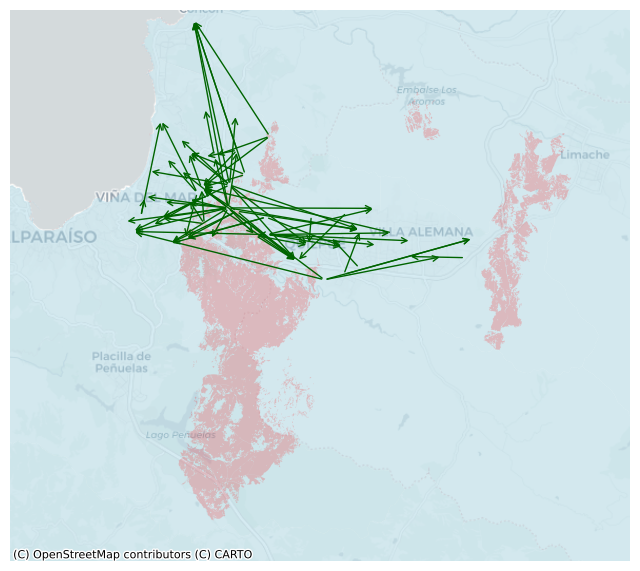

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))  

## First Figure
chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=axs, alpha=0.5)
incendio_gpd.plot(color='red', alpha=0.2, ax=axs)
# gdf_flows_filtered['PHONE_ID_wildfire']>=7].plot(column='change_category', ax=ax, alpha=1, legend=True, linewidth=0.5)

axs.set_xlim([-0.7975*1e7, -0.793*1e7])
axs.set_ylim([-3.925*1e6, -3.885*1e6])
axs.set_axis_off()

# Add basemap to the main figure
ctx.add_basemap(axs, source=ctx.providers.CartoDB.Positron)

gdf_flows_filtered_new=gdf_flows[gdf_flows['change_category'].isin(['New'])]
# Add arrows to indicate movement direction
for idx, row in gdf_flows_filtered_new[gdf_flows_filtered_new['PHONE_ID_wildfire']>=7].iterrows():
    if row['line'] is not None:
        # Extract the coordinates of the line (start and end points)
        x_start, y_start = row['line'].coords[0]
        x_end, y_end = row['line'].coords[-1]
        
        # Add an arrow indicating the movement direction
        axs.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                    arrowprops=dict(facecolor='darkgreen', edgecolor='darkgreen', arrowstyle='->', lw=1))




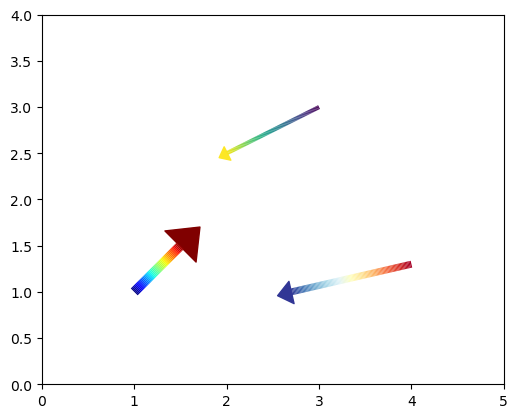

In [20]:
import matplotlib.pyplot as plt
import matplotlib.transforms
import matplotlib.path
import numpy as np
from matplotlib.collections import LineCollection

def rainbowarrow(ax, start, end, cmap="viridis", n=50,lw=3):
    cmap = plt.get_cmap(cmap,n)
    # Arrow shaft: LineCollection
    x = np.linspace(start[0],end[0],n)
    y = np.linspace(start[1],end[1],n)
    points = np.array([x,y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, linewidth=lw)
    lc.set_array(np.linspace(0,1,n))
    ax.add_collection(lc)
    # Arrow head: Triangle
    tricoords = [(0,-0.4),(0.5,0),(0,0.4),(0,-0.4)]
    angle = np.arctan2(end[1]-start[1],end[0]-start[0])
    rot = matplotlib.transforms.Affine2D().rotate(angle)
    tricoords2 = rot.transform(tricoords)
    tri = matplotlib.path.Path(tricoords2, closed=True)
    ax.scatter(end[0],end[1], c=1, s=(4*lw)**2, marker=tri, cmap=cmap,vmin=0)
    ax.autoscale_view()

fig,ax = plt.subplots()
ax.axis([0,5,0,4])
ax.set_aspect("equal")

rainbowarrow(ax, (3,3), (2,2.5), cmap="viridis", n=100,lw=3)
rainbowarrow(ax, (1,1), (1.5,1.5), cmap="jet", n=50,lw=7)
rainbowarrow(ax, (4,1.3), (2.7,1.0), cmap="RdYlBu", n=100,lw=5)

plt.show()


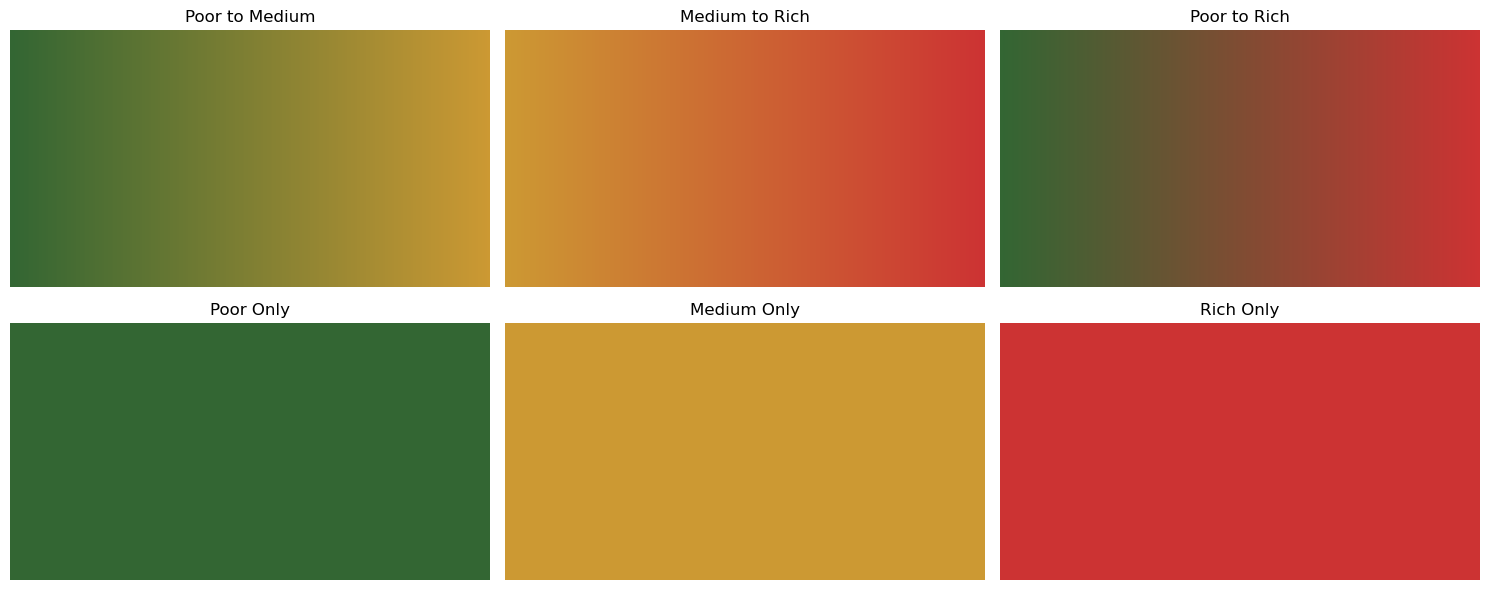

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define base colours for each class
poor_color = (0.2, 0.4, 0.2)  # Dark Green for Poor
medium_color = (0.8, 0.6, 0.2)  # Yellow for Medium
rich_color = (0.8, 0.2, 0.2)  # Red for Rich

# Define colour transition colormaps (gradual change)
def create_transition_colormap(start_color, end_color, name):
    return LinearSegmentedColormap.from_list(name, [start_color, end_color])

# Define colour same-colour colormaps (no transition)
def create_same_color_colormap(color, name):
    return LinearSegmentedColormap.from_list(name, [color, color])

# Create the colormaps
colormap_poor_medium = create_transition_colormap(poor_color, medium_color, 'Poor_to_Medium')
colormap_medium_rich = create_transition_colormap(medium_color, rich_color, 'Medium_to_Rich')
colormap_poor_rich = create_transition_colormap(poor_color, rich_color, 'Poor_to_Rich')

colormap_poor_only = create_same_color_colormap(poor_color, 'Poor_Only')
colormap_medium_only = create_same_color_colormap(medium_color, 'Medium_Only')
colormap_rich_only = create_same_color_colormap(rich_color, 'Rich_Only')

# Plotting the colormaps to visualize
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

# Display colormaps
colormap_list = [colormap_poor_medium, colormap_medium_rich, colormap_poor_rich,
                 colormap_poor_only, colormap_medium_only, colormap_rich_only]

titles = ['Poor to Medium', 'Medium to Rich', 'Poor to Rich',
          'Poor Only', 'Medium Only', 'Rich Only']

for i, ax in enumerate(axs.flat):
    img = np.linspace(0, 1, 256).reshape(1, -1)
    img = np.vstack((img, img))
    ax.imshow(img, aspect='auto', cmap=colormap_list[i])
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [22]:
gdf_flows['color_category'] = (
    gdf_flows['quantile_pop_bins_percent_bachelor_current_before_wildfire'].astype(str) + 
    gdf_flows['quantile_pop_bins_percent_bachelor_current_after_wildfire'].astype(str)
)


In [23]:
# Create the dictionary mapping categories to corresponding colormaps
category_colormap_dict = {
    "LowLow": colormap_poor_only,     
    "LowMedium": colormap_poor_medium,
    "LowHigh": colormap_poor_rich,
    "MediumLow": colormap_poor_medium.reversed(),
    "MediumMedium": colormap_medium_only.reversed(),
    "MediumHigh": colormap_medium_rich,
    "HighLow": colormap_poor_rich.reversed(), 
    "HighMedium": colormap_medium_rich.reversed(),
    "HighHigh": colormap_rich_only} 

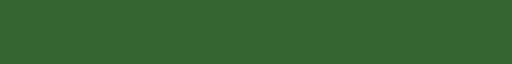

In [24]:
category_colormap_dict['LowLow']

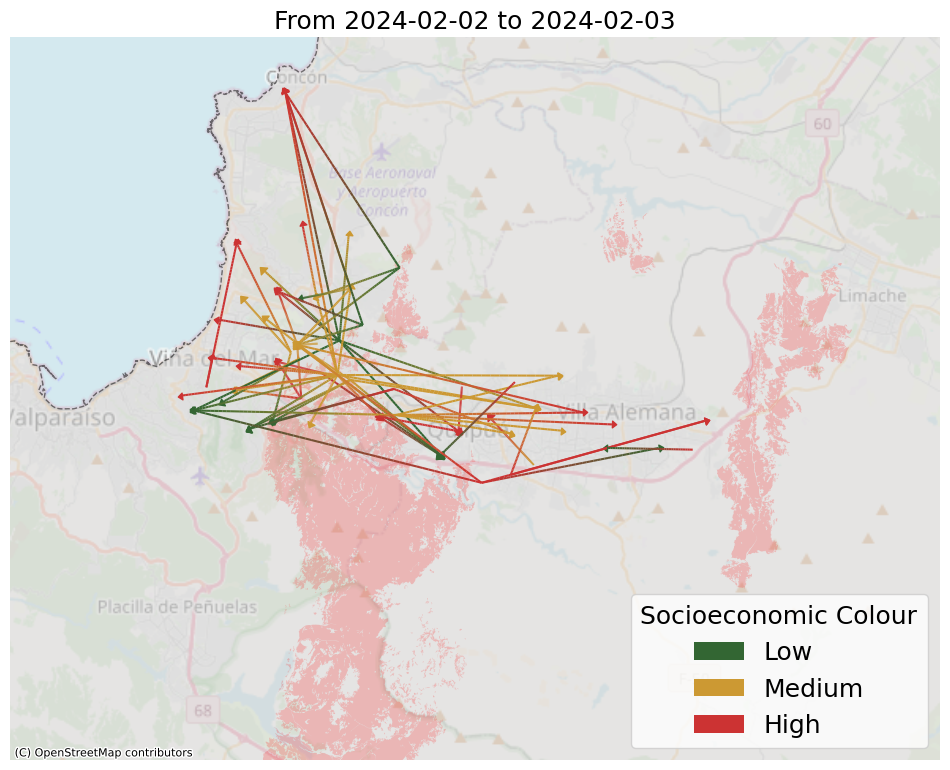

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12))  

## First Figure
chile_border_adm1[chile_border_adm1['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightgray', ax=axs, alpha=0.5,
                                                                               edgecolor='black', linestyle='--', linewidth=1)
incendio_gpd.plot(color='red', alpha=0.2, ax=axs)
# gdf_flows_filtered['PHONE_ID_wildfire']>=7].plot(column='change_category', ax=ax, alpha=1, legend=True, linewidth=0.5)

axs.set_xlim([-0.7975*1e7, -0.793*1e7])
axs.set_ylim([-3.918*1e6, -3.883*1e6])
axs.set_axis_off()

axs.set_title('From 2024-02-02 to 2024-02-03', fontsize=18)

# Add basemap to the main figure
ctx.add_basemap(axs, source=ctx.providers.OpenStreetMap.Mapnik)

for img in axs.get_images():
        img.set_alpha(0.5)

gdf_flows_filtered_new=gdf_flows[gdf_flows['change_category'].isin(['New', 'Increased'])]
# Add arrows to indicate movement direction
for idx, row in gdf_flows_filtered_new[gdf_flows_filtered_new['PHONE_ID_wildfire']>=7].iterrows():
    if row['line'] is not None:
        # Extract the coordinates of the line (start and end points)
        x_start, y_start = row['line'].coords[0]
        x_end, y_end = row['line'].coords[-1]
        
        # Add an arrow indicating the movement direction
        rainbowarrow(axs, start=(x_start, y_start), end=(x_end, y_end),
                     cmap=category_colormap_dict[row['color_category']], n=50,lw=1.5)


rect1 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=poor_color, alpha=1)
rect2 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=medium_color, alpha=1)
rect3 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=rich_color, alpha=1)
handles_to_append = [rect1, rect2, rect3]

# Explicitly specify handles and labels for the legend
handles, labels = [], []
for line in axs.get_lines():
    handles.append(line)
    labels.append(line.get_label())
handles.extend(handles_to_append)

labels_to_append = ['Low', 'Medium', 'High']
labels.extend(labels_to_append)

axs.legend(handles, labels, fontsize=18, loc='lower right', 
           title='Socioeconomic Colour', title_fontsize=18)

fig.savefig('../visuals_created/map_ses_flows1',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)

plt.show();

In [26]:
## here should be changed - can be away from the homes!!

def create_gdf_flows(df, day, day_before, zonas_geo):

    day=pd.to_datetime(day)

    if not day_before:
        day_before=day-pd.Timedelta(days=1)
    else:
        day_before=pd.to_datetime(day_before)

    day_base=day-pd.Timedelta(weeks=1)
    day_before_base=day_before-pd.Timedelta(weeks=1)

    spatial_currentlocations_daybefore=(df[(df['date'].isin([day_before]))])

    spatial_currentlocations_day=(df[(homelocations_merged_evacuated['date'].isin([day]))])

    spatial_currentlocations_daybeforebase=(df[(df['date'].isin([day_before_base]))
                                &(df['current_bts_id']==df['home_bts_id'])])

    spatial_currentlocations_daybase=(df[(df['date'].isin([day_base]))])

    flow_baseline=(spatial_currentlocations_daybeforebase[['date', 'PHONE_ID', 'ZONA_current', 'quantile_pop_bins_percent_bachelor_current']]
                    .merge(spatial_currentlocations_daybase[['PHONE_ID', 'ZONA_current', 'quantile_pop_bins_percent_bachelor_current']],
                            on='PHONE_ID', how='inner', suffixes=('_before', '_after'))
                    .groupby(['ZONA_current_before','ZONA_current_after'])
                    .agg({'PHONE_ID':'count',
                          'quantile_pop_bins_percent_bachelor_current_before':'first',
                          'quantile_pop_bins_percent_bachelor_current_after':'first'})
                    .reset_index()
                    )

    flow_wildfire=(spatial_currentlocations_daybefore[['date', 'PHONE_ID', 'ZONA_current', 'quantile_pop_bins_percent_bachelor_current']]
                    .merge(spatial_currentlocations_day[['PHONE_ID', 'ZONA_current', 'quantile_pop_bins_percent_bachelor_current']],
                            on='PHONE_ID', how='inner', suffixes=('_before', '_after'))
                    .groupby(['ZONA_current_before','ZONA_current_after'])
                    .agg({'PHONE_ID':'count',
                          'quantile_pop_bins_percent_bachelor_current_before':'first',
                          'quantile_pop_bins_percent_bachelor_current_after':'first'})
                    .reset_index()
                    )
    
    flows=flow_baseline.merge(flow_wildfire, on=['ZONA_current_before', 'ZONA_current_after'], how='outer', suffixes=('_baseline', '_wildfire'))

    flows['change']=flows['PHONE_ID_wildfire']-flows['PHONE_ID_baseline']/flows['PHONE_ID_baseline']*100

    bins = [-float('inf'), -10, 10, float('inf')]
    labels = ['Significant Decrease', 'Stable', 'Significant Increase']
    flows['change_category'] = pd.cut(flows['change'], bins=bins, labels=labels)
    
    flows['change_category'] = flows['change_category'].cat.add_categories(['New', 'Disappeared'])
    flows.loc[flows['PHONE_ID_baseline'].isna()&~flows['PHONE_ID_wildfire'].isna(), 'change_category'] = 'New'
    flows.loc[~flows['PHONE_ID_baseline'].isna()&flows['PHONE_ID_wildfire'].isna(), 'change_category'] = 'Disappeared'

    zonas_geo['centroid']=zonas_geo.centroid
    zonas_geo = gpd.GeoDataFrame(zonas_geo, geometry='centroid')

    zonas_geo_before = zonas_geo[['ZONA', 'centroid']].rename(columns={'ZONA': 'ZONA_current_before', 'centroid': 'geometry_before'})
    zonas_geo_after = zonas_geo[['ZONA', 'centroid']].rename(columns={'ZONA': 'ZONA_current_after', 'centroid': 'geometry_after'})
    
    # Merge the geo_antennas data with flows for both before and after
    flows = flows.merge(zonas_geo_before, on='ZONA_current_before', how='left')
    flows = flows.merge(zonas_geo_after, on='ZONA_current_after', how='left')
    
    # Ensure both 'geometry_before' and 'geometry_after' are valid geometries
    flows['line'] = flows.apply(lambda row: LineString([row['geometry_before'].coords[0], row['geometry_after'].coords[0]]) 
                                if row['geometry_before'] is not None and row['geometry_after'] is not None else None, axis=1)
    
    gdf_flows = gpd.GeoDataFrame(flows, geometry='line', crs=3857)
    

    return gdf_flows
    

In [27]:
gdf_flows2=create_gdf_flows(homelocations_merged_evacuated, day='2024-02-05', day_before='2024-02-04', zonas_geo=zonas_geo)

gdf_flows2['color_category'] = (
    gdf_flows2['quantile_pop_bins_percent_bachelor_current_before_wildfire'].astype(str) + 
    gdf_flows2['quantile_pop_bins_percent_bachelor_current_after_wildfire'].astype(str)
)

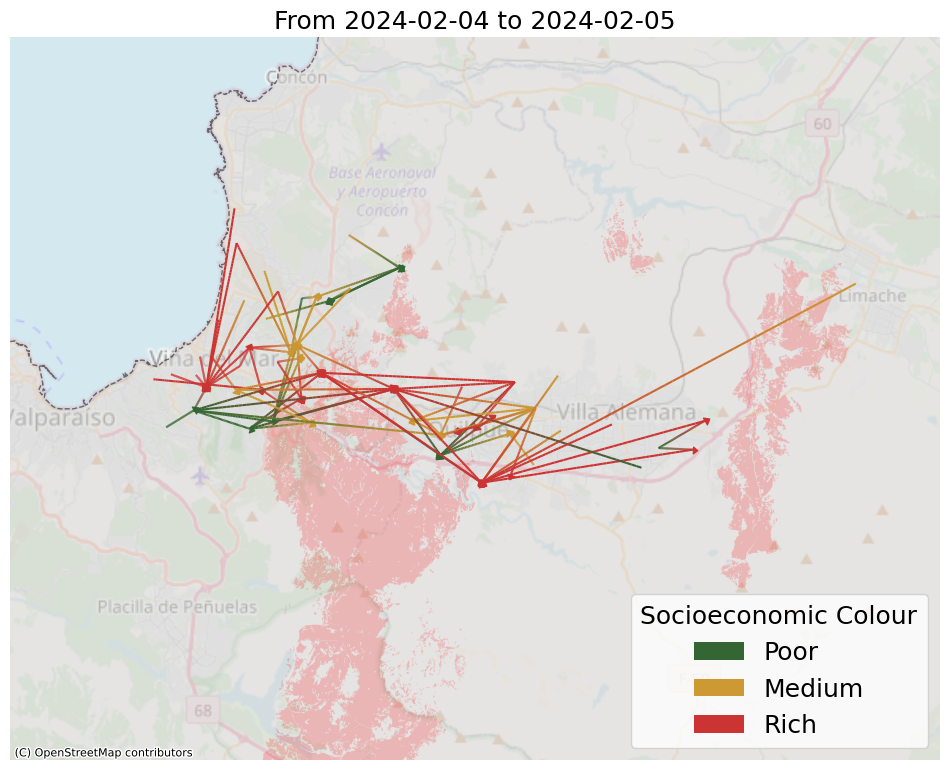

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12))  

## First Figure
chile_border_adm1[chile_border_adm1['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightgray', ax=axs, alpha=0.5,
                                                                               edgecolor='black', linestyle='--', linewidth=1)
incendio_gpd.plot(color='red', alpha=0.2, ax=axs)
# gdf_flows_filtered['PHONE_ID_wildfire']>=7].plot(column='change_category', ax=ax, alpha=1, legend=True, linewidth=0.5)

axs.set_xlim([-0.7975*1e7, -0.793*1e7])
axs.set_ylim([-3.918*1e6, -3.883*1e6])
axs.set_axis_off()

axs.set_title('From 2024-02-04 to 2024-02-05', fontsize=18)

# Add basemap to the main figure
ctx.add_basemap(axs, source=ctx.providers.OpenStreetMap.Mapnik)

for img in axs.get_images():
        img.set_alpha(0.5)

gdf_flows_filtered_new2=gdf_flows2[gdf_flows2['change_category'].isin(['New', 'Increased'])]
gdf_flows_filtered_new2=gdf_flows_filtered_new2[gdf_flows_filtered_new2['ZONA_current_before']!=gdf_flows_filtered_new2['ZONA_current_after']]
	
# Add arrows to indicate movement direction
for idx, row in gdf_flows_filtered_new2[gdf_flows_filtered_new2['PHONE_ID_wildfire']>=7].iterrows():
    if row['line'] is not None:
        # Extract the coordinates of the line (start and end points)
        x_start, y_start = row['line'].coords[0]
        x_end, y_end = row['line'].coords[-1]
        
        # Add an arrow indicating the movement direction
        rainbowarrow(axs, start=(x_start, y_start), end=(x_end, y_end),
                     cmap=category_colormap_dict[row['color_category']], n=50,lw=1.5)


rect1 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=poor_color, alpha=1)
rect2 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=medium_color, alpha=1)
rect3 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=rich_color, alpha=1)
handles_to_append = [rect1, rect2, rect3]

# Explicitly specify handles and labels for the legend
handles, labels = [], []
for line in axs.get_lines():
    handles.append(line)
    labels.append(line.get_label())
handles.extend(handles_to_append)

labels_to_append = ['Poor', 'Medium', 'Rich']
labels.extend(labels_to_append)

axs.legend(handles, labels, fontsize=18, loc='lower right', 
           title='Socioeconomic Colour', title_fontsize=18)

fig.savefig('../visuals_created/map_ses_flows2',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)

plt.show();

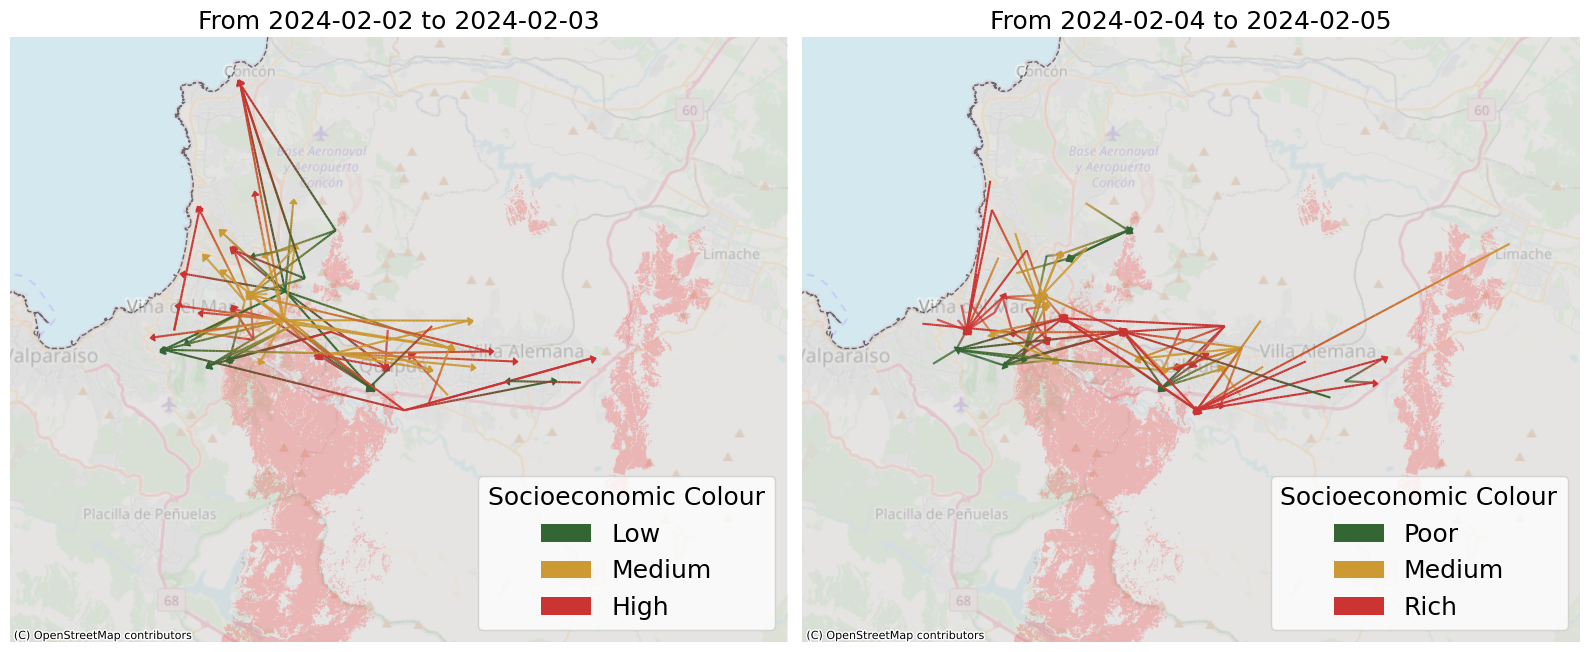

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))  

## First Figure
chile_border_adm1[chile_border_adm1['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightgray', ax=axs[0], alpha=0.5,
                                                                               edgecolor='black', linestyle='--', linewidth=1)
incendio_gpd.plot(color='red', alpha=0.2, ax=axs[0])

axs[0].set_xlim([-0.7975*1e7, -0.793*1e7])
axs[0].set_ylim([-3.918*1e6, -3.883*1e6])
axs[0].set_axis_off()

axs[0].set_title('From 2024-02-02 to 2024-02-03', fontsize=18)

# Add basemap to the main figure
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)

for img in axs[0].get_images():
        img.set_alpha(0.5)

gdf_flows_filtered_new=gdf_flows[gdf_flows['change_category'].isin(['New', 'Increased'])]
# Add arrows to indicate movement direction
for idx, row in gdf_flows_filtered_new[gdf_flows_filtered_new['PHONE_ID_wildfire']>=7].iterrows():
    if row['line'] is not None:
        # Extract the coordinates of the line (start and end points)
        x_start, y_start = row['line'].coords[0]
        x_end, y_end = row['line'].coords[-1]
        
        # Add an arrow indicating the movement direction
        rainbowarrow(axs[0], start=(x_start, y_start), end=(x_end, y_end),
                     cmap=category_colormap_dict[row['color_category']], n=50,lw=1.5)


rect1 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=poor_color, alpha=1)
rect2 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=medium_color, alpha=1)
rect3 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=rich_color, alpha=1)
handles_to_append = [rect1, rect2, rect3]

# Explicitly specify handles and labels for the legend
handles, labels = [], []
for line in axs[0].get_lines():
    handles.append(line)
    labels.append(line.get_label())
handles.extend(handles_to_append)

labels_to_append = ['Low', 'Medium', 'High']
labels.extend(labels_to_append)

axs[0].legend(handles, labels, fontsize=18, loc='lower right', 
           title='Socioeconomic Colour', title_fontsize=18)

## Second Figure
chile_border_adm1[chile_border_adm1['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightgray', ax=axs[1], alpha=0.5,
                                                                               edgecolor='black', linestyle='--', linewidth=1)
incendio_gpd.plot(color='red', alpha=0.2, ax=axs[1])

axs[1].set_xlim([-0.7975*1e7, -0.793*1e7])
axs[1].set_ylim([-3.918*1e6, -3.883*1e6])
axs[1].set_axis_off()

axs[1].set_title('From 2024-02-04 to 2024-02-05', fontsize=18)

# Add basemap to the main figure
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)

for img in axs[1].get_images():
        img.set_alpha(0.5)

gdf_flows_filtered_new2=gdf_flows2[gdf_flows2['change_category'].isin(['New', 'Increased'])]
gdf_flows_filtered_new2=gdf_flows_filtered_new2[gdf_flows_filtered_new2['ZONA_current_before']!=gdf_flows_filtered_new2['ZONA_current_after']]

# Add arrows to indicate movement direction
for idx, row in gdf_flows_filtered_new2[gdf_flows_filtered_new2['PHONE_ID_wildfire']>=7].iterrows():
    if row['line'] is not None:
        # Extract the coordinates of the line (start and end points)
        x_start, y_start = row['line'].coords[0]
        x_end, y_end = row['line'].coords[-1]
        
        # Add an arrow indicating the movement direction
        rainbowarrow(axs[1], start=(x_start, y_start), end=(x_end, y_end),
                     cmap=category_colormap_dict[row['color_category']], n=50,lw=1.5)


rect1 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=poor_color, alpha=1)
rect2 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=medium_color, alpha=1)
rect3 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color=rich_color, alpha=1)
handles_to_append = [rect1, rect2, rect3]

# Explicitly specify handles and labels for the legend
handles, labels = [], []
for line in axs[1].get_lines():
    handles.append(line)
    labels.append(line.get_label())
handles.extend(handles_to_append)

labels_to_append = ['Poor', 'Medium', 'Rich']
labels.extend(labels_to_append)

axs[1].legend(handles, labels, fontsize=18, loc='lower right', 
           title='Socioeconomic Colour', title_fontsize=18)

plt.tight_layout()

fig.savefig('../visuals_created/map_ses_flows3',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)

plt.show();

In [30]:
# Shut down the kernel to release memory
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}